In [18]:
%%writefile src/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for 
LIBS benchmark classification dataset.
"""

import os
import torch
import pickle
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from load_libs_data import load_contest_train_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from utils import resample_spectra_df

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    batch_size: int, 
    num_classes: int,
    device: torch.device,
    num_workers: int=NUM_WORKERS, 
    split_rate: float=0.5,
    random_st: int=102,
    spectra_count: int=100
):
    """Creates training and validation DataLoaders.
    ...
    """
    
    pickle_file_path = "data/data.pkl"
    
    if os.path.exists(pickle_file_path):
        with open(pickle_file_path, 'rb') as f:
            data_dict = pickle.load(f)
        X = data_dict['X']
        y = data_dict['y']
        samples = data_dict['samples']
    else:
        X, y, samples = load_contest_train_dataset(train_dir, spectra_count)
        with open(pickle_file_path, 'wb') as f:
            pickle.dump({'X': X, 'y': y, 'samples': samples}, f)
        
    wavelengths = X.columns
    
    new_wave = np.arange(350, 700, 0.05)
    X_new = resample_spectra_df(X, wavelengths, new_wave)
    del X
    X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size=split_rate, random_state=random_st, stratify=samples, shuffle=True)
    del y, samples, X_new
    
    y_train = y_train-1
    y_val = y_val-1
    
    scaler = Normalizer(norm='max')
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    X_train = torch.from_numpy(X_train).float()
    X_val = torch.from_numpy(X_val).float()
    
    y_train = torch.from_numpy(np.array(y_train)).long()
    y_val = torch.from_numpy(np.array(y_val)).long()
    
    X_train = X_train.to(device)
    X_val = X_val.to(device)
    y_train = y_train.to(device)
    y_val = y_val.to(device)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_val, y_val)
    
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, test_dataloader, y_train




Overwriting src/data_setup.py


In [67]:
%%writefile src/model_builder.py
"""
Contains PyTorch model code to instantiate an MLP model.
"""
import torch
from torch import nn

class SimpleMLP(nn.Module):
    """Creates a simple MLP architecture.

    Args:
        input_shape: An integer indicating the size of the input vector.
        hidden_units1: An integer indicating the number of hidden units in the first hidden layer.
        hidden_units2: An integer indicating the number of hidden units in the second hidden layer.
        output_shape: An integer indicating the number of output units.
    """
    def __init__(self, input_shape: int, hidden_units1: int, hidden_units2: int, output_shape: int) -> None:
        super().__init__()
        
        # First hidden layer
        self.hidden_layer_1 = nn.Sequential(
            nn.Linear(input_shape, hidden_units1),
            nn.ReLU()
        )
        
        # Second hidden layer
        self.hidden_layer_2 = nn.Sequential(
            nn.Linear(hidden_units1, hidden_units2),
            nn.ReLU()
        )

        # Output layer
        self.output_layer = nn.Linear(hidden_units2, output_shape)
    
    def forward(self, x: torch.Tensor):
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x


Overwriting src/model_builder.py


In [17]:
%%writefile src/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch
import wandb
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from loss_penalization import sparseloc
import time

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               regularization_type,
               reg_lambda
               ) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)
      # print(y_pred.shape)
      # print(y.shape)
      # 2. Calculate  and accumulate loss

      if regularization_type == "vanilla":
          # No regularization
          reg_term = 0 
      elif regularization_type == "L1":
          # Apply L1 regularization
          reg_term = torch.sum( torch.abs(model.hidden_layer_1[0].weight))
      elif regularization_type == "sparseloc":
          # Apply Sparse Localized regularization
          reg_term = sparseloc(model.hidden_layer_1[0].weight)
      else:
          raise ValueError("Invalid regularization type. Options are 'vanilla', 'L1', 'sparseloc'.")
           

      # loss
      loss = loss_fn(y_pred, y) + reg_lambda * reg_term
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.no_grad():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)
          # print(test_pred_logits.shape)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          reg_lambda: float,
          regularization_type: str) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  run_name = f"{regularization_type}_lambda_{reg_lambda}"
    
    # Initialize the wandb run with the given parameters and name
  wandb.init(project='custom_loss_sparsity', entity='jakubv', name=run_name, tags=[f"{regularization_type}", f"lambda_{reg_lambda}"])
  wandb.watch(model)  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device,
                                          regularization_type = regularization_type,
                                          reg_lambda = reg_lambda)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )
      wandb.log({
        "epoch": epoch+1,
        "lambda": reg_lambda,
        "training_loss": train_loss, 
        "train_acc": train_acc,
        "validation_loss": test_loss,
        "validation_acc": test_acc
      })  

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  wandb.finish()  
  # Return the filled results at the end of the epochs

  return results

Overwriting src/engine.py


In [14]:
%%writefile src/run_experiment.py

import subprocess

# List of lambda values you want to experiment with
lambda_values = [0.05, 0.02, 0.01, 0.005, 0.002, 0.001]

# Dictionary to hold metrics for each lambda value
all_metrics = {}

# Run the training script with each lambda value
for lambda_val in lambda_values:
    # Run the script. This assumes that you have added argparse to your train.py to accept lambda as a parameter
    subprocess.run(['python', 'src/train.py', '--reg_lambda', str(lambda_val), '--reg_type', 'L1'])


Overwriting src/run_experiment.py


In [69]:
import torch

tensor_object = torch.rand(1024, 40000)

# If you're planning to run these lines in a loop, consider using batch operations for speedup

# Extract W1 and initialize W1_out to zeros to save memory.
W1 = tensor_object[0,:]
W1_out = torch.zeros(W1.size(0), W1.size(0))

# Calculate the outer product in-place to save memory.
torch.outer(W1, W1, out=W1_out)

# Zero out the elements above the diagonal, including the diagonal
W1_out.tril_(-1)

# Zero out elements further than N diagonals below the diagonal in-place
W1_out.triu_(-4)

W1_out



tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0050, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0520, 0.0439, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1077, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.2728, 0.1715, 0.0000]])

# Simple visualization of first 5 hidden neurons

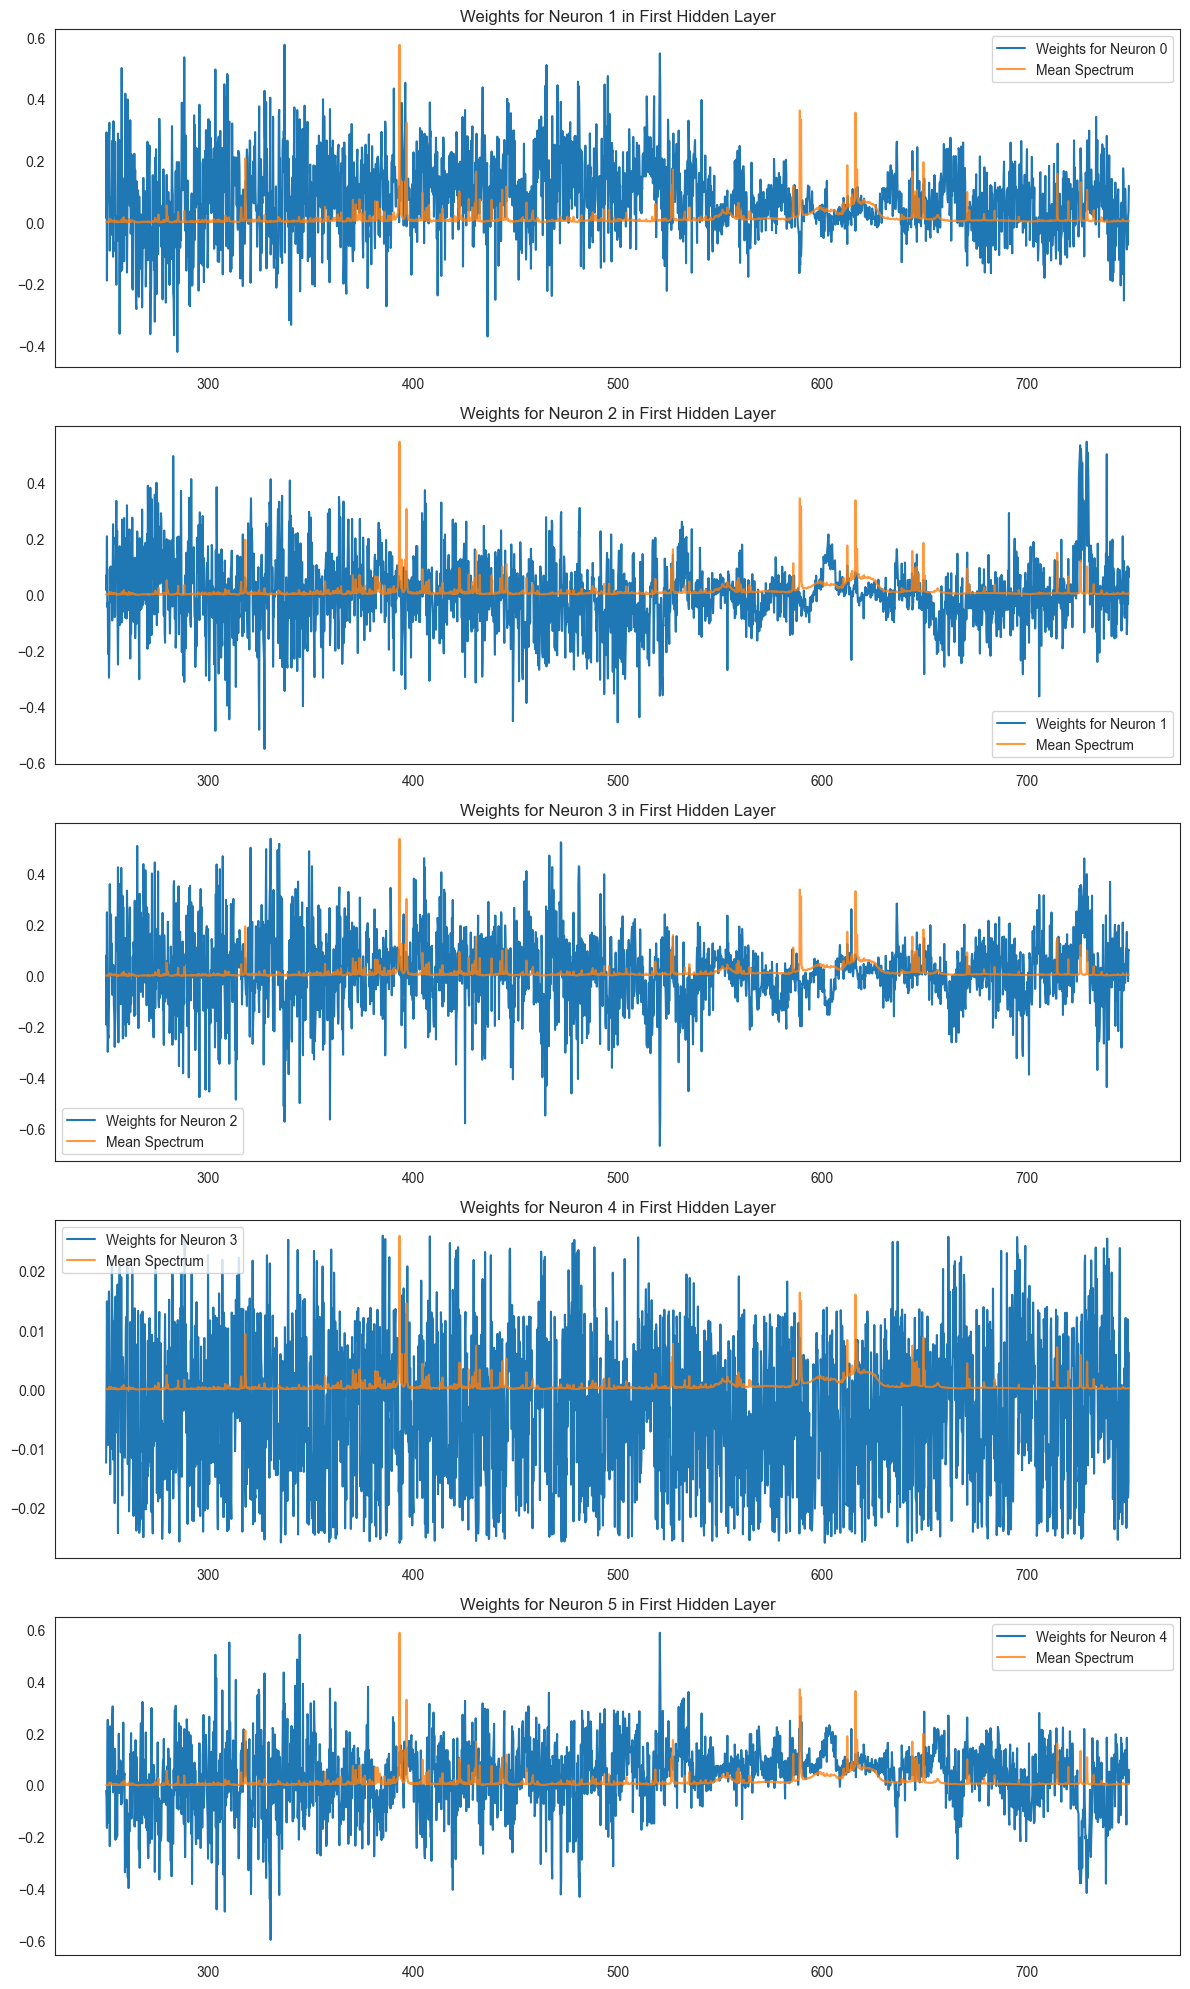

In [156]:


from src.model_builder import SimpleMLP
import matplotlib.pyplot as plt
import torch
import pandas as pd
from src.utils import resample_spectra_df



pickle_file_path = "data/data.pkl"
if True:
    data_dict = pd.read_pickle(pickle_file_path)
    X = data_dict['X']
wavelengths = X.columns
new_wave = np.arange(250, 750, 0.2)
X_new = resample_spectra_df(X, wavelengths, new_wave)





# Calculate the mean spectrum
mean_spectrum = X_new.mean(axis=0)

# Initialize the model with the same architecture as the saved model
model = SimpleMLP(input_shape=2500, hidden_units1=128, hidden_units2=64, output_shape=12)

def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Load the model from the saved state_dict
model = load_model(model, "models/vanilla_mlp_model.pth")

# Extract the weights for the first hidden layer
hidden1_weights = model.hidden_layer_1[0].weight.data

# Plot the weights for the first three neurons
plt.figure(figsize=(12, 20))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(new_wave, hidden1_weights[i], label=f"Weights for Neuron {i}")
    norm_f = hidden1_weights[i].max().item() / mean_spectrum.max()
    plt.plot(new_wave, mean_spectrum*norm_f, label="Mean Spectrum", alpha=0.8)
    plt.title(f"Weights for Neuron {i+1} in First Hidden Layer")
    plt.legend()
plt.tight_layout()
plt.show()


In [119]:
import torch
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from src.model_builder import SimpleMLP
from src.utils import resample_spectra_df

# Function to load model
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Read pickle file
pickle_file_path = "data/data.pkl"
data_dict = pd.read_pickle(pickle_file_path)
X = data_dict['X']

# Resample spectra
wavelengths = X.columns
new_wave = np.arange(250, 750, 0.2)
X_new = resample_spectra_df(X, wavelengths, new_wave)

# Calculate the mean spectrum
mean_spectrum = X_new.mean(axis=0)
variance_spectrum = X_new.var(axis=0)

# Initialize and load the model
model = SimpleMLP(input_shape=2500, hidden_units1=128, hidden_units2=64, output_shape=12)
# model = load_model(model, "models/sparse_simple_mlp_model.pth")
model = load_model(model, "models/vanilla_mlp_model.pth")

# Extract the weights
hidden1_weights = model.hidden_layer_1[0].weight.data

# Create subplot figure with Plotly
fig = make_subplots(rows=5, cols=1, subplot_titles=[f"Weights for Neuron {i+1} in First Hidden Layer" for i in range(5)])


# Populate the subplots
for i in range(5):
    k = i +1
    weights_data = hidden1_weights[k].cpu().numpy()
    fig.add_trace(
        go.Scatter(x=new_wave, y=weights_data, mode='lines', name=f"Weights for Neuron {k+1}"),
        row=i+1, col=1
    )
    
    norm_f = abs(hidden1_weights[k]).max().item() / mean_spectrum.max()
    fig.add_trace(
        go.Scatter(
            x=new_wave,
            y=mean_spectrum * norm_f,
            mode='lines',
            name="Mean Spectrum",
            line=dict(color='rgba(0,100,80,0.5)')  # RGBA color format, the last value is alpha (0.7 here)
        ),
        row=i+1, col=1
    )
# Update layout and show the plot
fig.update_layout(height=1800, width=1000, title_text="Subplots of Weights and Mean Spectrum")
fig.show()


# Reordered neurons (first are with the most connections)

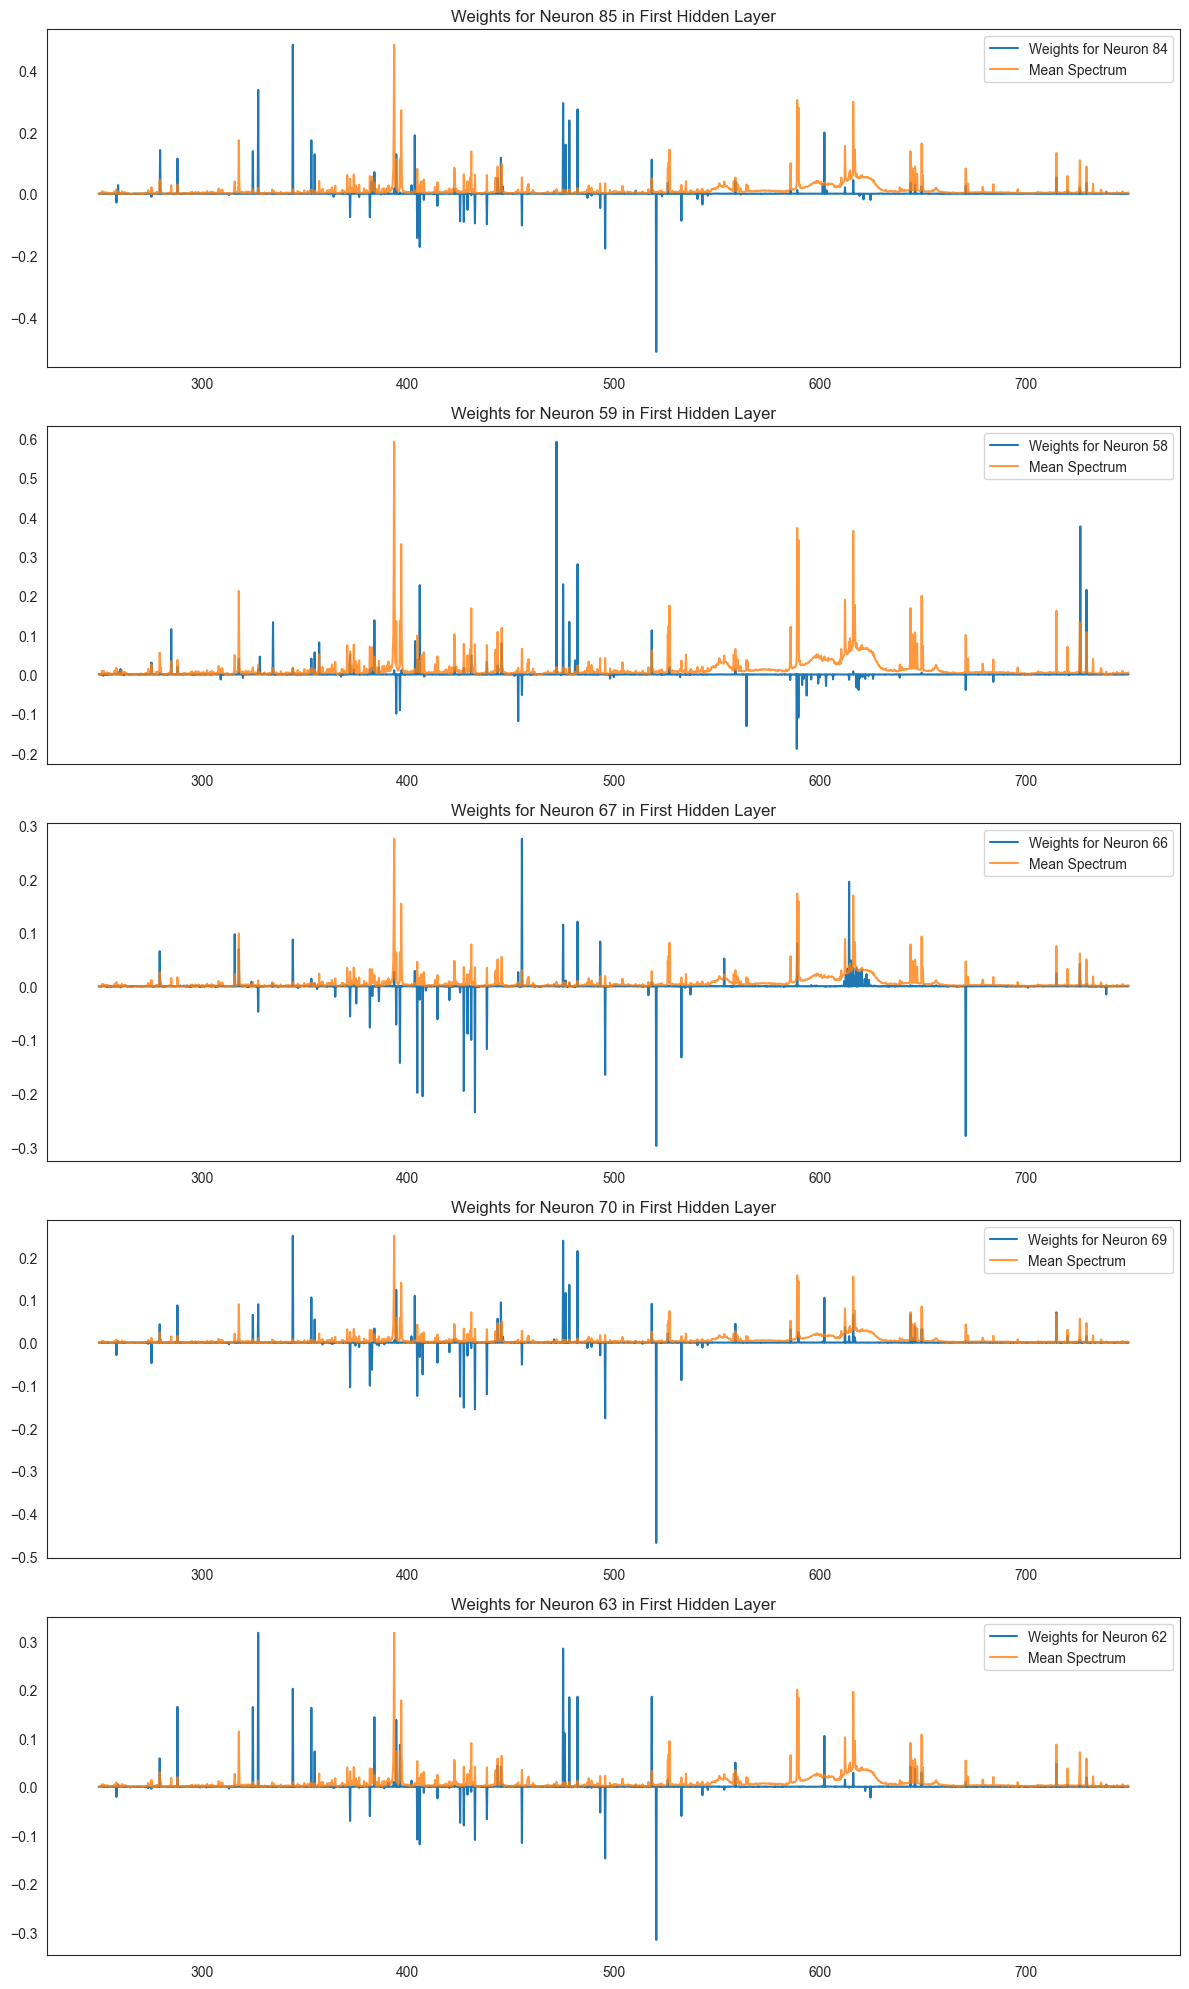

In [122]:
from src.model_builder import SimpleMLP
import matplotlib.pyplot as plt
import torch
import pandas as pd
from src.utils import resample_spectra_df
import numpy as np

# Load data and resample
pickle_file_path = "data/data.pkl"
data_dict = pd.read_pickle(pickle_file_path)
X = data_dict['X']
wavelengths = X.columns
new_wave = np.arange(250, 750, 0.2)
X_new = resample_spectra_df(X, wavelengths, new_wave)

# Calculate mean spectrum
mean_spectrum = X_new.mean(axis=0)

# Initialize and load model
model = SimpleMLP(input_shape=2500, hidden_units1=128, hidden_units2=64, output_shape=12)
model = load_model(model, "models/sparse_simple_mlp_model.pth")

# Extract first hidden layer weights and calculate the sum of absolute weights for each neuron
hidden1_weights = model.hidden_layer_1[0].weight.data.cpu().numpy()
sum_abs_weights = np.sum(np.abs(hidden1_weights), axis=1)

# Get the indices that would sort the sum of absolute weights in descending order
sorted_indices = np.argsort(sum_abs_weights)[::-1]

# Reorder the weights based on the sorted indices
hidden1_weights = hidden1_weights[sorted_indices]

# Plotting
plt.figure(figsize=(12, 20))
for i in range(5):  # Change this range if you want to plot more or fewer neurons
    plt.subplot(5, 1, i + 1)
    plt.plot(new_wave, hidden1_weights[i], label=f"Weights for Neuron {sorted_indices[i]}")
    norm_f = hidden1_weights[i].max() / mean_spectrum.max()
    plt.plot(new_wave, mean_spectrum * norm_f, label="Mean Spectrum", alpha=0.8)
    plt.title(f"Weights for Neuron {sorted_indices[i] + 1} in First Hidden Layer")
    plt.legend()
plt.tight_layout()
plt.show()


# Network architectural plot (simple one)

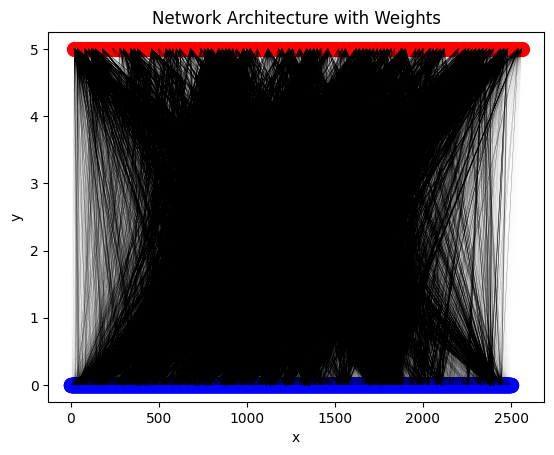

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Your actual weight data
# For example, if you have your weights in a PyTorch tensor, convert them to a numpy array
# weights_data = hidden1_weights.cpu().numpy()
weights_data = hidden1_weights.cpu().numpy()

# Initialize positions for input and hidden layer neurons
input_size = weights_data.shape[1]
hidden_size = weights_data.shape[0]
input_x = np.linspace(0, input_size-1, input_size)
input_y = np.zeros(input_size)

# Scale factor for stretching the hidden layer
scale_factor = 20

hidden_x = np.linspace(1 * scale_factor, hidden_size * scale_factor, hidden_size)
hidden_y = np.ones(hidden_size) * 5  # Neurons in the hidden layer will be plotted at y=5

# Create plot
fig, ax = plt.subplots()

# Plot input layer
ax.scatter(input_x, input_y, s=100, c='blue', label='Input Layer')

# Plot hidden layer
ax.scatter(hidden_x, hidden_y, s=100, c='red', label='Hidden Layer')

# Add connections (weights)
for i in range(input_size):
    for j in range(hidden_size):
        weight = weights_data[j, i]
        line_width = np.abs(weight) #*5  # Scale the line thickness
        ax.plot([input_x[i], hidden_x[j]], [input_y[i], hidden_y[j]], c='black', linewidth=line_width, alpha=0.5)

# Add legends and labels
# plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Network Architecture with Weights')
plt.show()


c:\Users\kubov\.conda\envs\semi_supervised\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



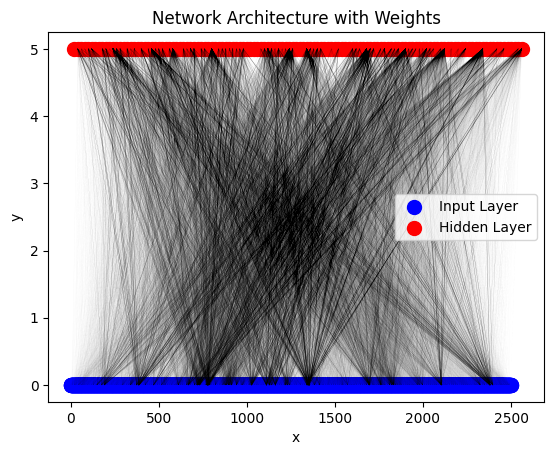

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Your actual weight data
# For example, if you have your weights in a PyTorch tensor, convert them to a numpy array
# weights_data = hidden1_weights.cpu().numpy()
weights_data = hidden1_weights.cpu().numpy()

# Initialize positions for input and hidden layer neurons
input_size = weights_data.shape[1]
hidden_size = weights_data.shape[0]
input_x = np.linspace(0, input_size-1, input_size)
input_y = np.zeros(input_size)

# Scale factor for stretching the hidden layer
scale_factor = 20

hidden_x = np.linspace(1 * scale_factor, hidden_size * scale_factor, hidden_size)
hidden_y = np.ones(hidden_size) * 5  # Neurons in the hidden layer will be plotted at y=5

# Create plot
fig, ax = plt.subplots()

# Plot input layer
ax.scatter(input_x, input_y, s=100, c='blue', label='Input Layer')

# Plot hidden layer
ax.scatter(hidden_x, hidden_y, s=100, c='red', label='Hidden Layer')

# Add connections (weights)
for i in range(input_size):
    for j in range(hidden_size):
        weight = weights_data[j, i]
        line_width = np.abs(weight) #*5  # Scale the line thickness
        ax.plot([input_x[i], hidden_x[j]], [input_y[i], hidden_y[j]], c='black', linewidth=line_width, alpha=0.5)

# Add legends and labels
# plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Network Architecture with Weights')
plt.show()


# Circle plots

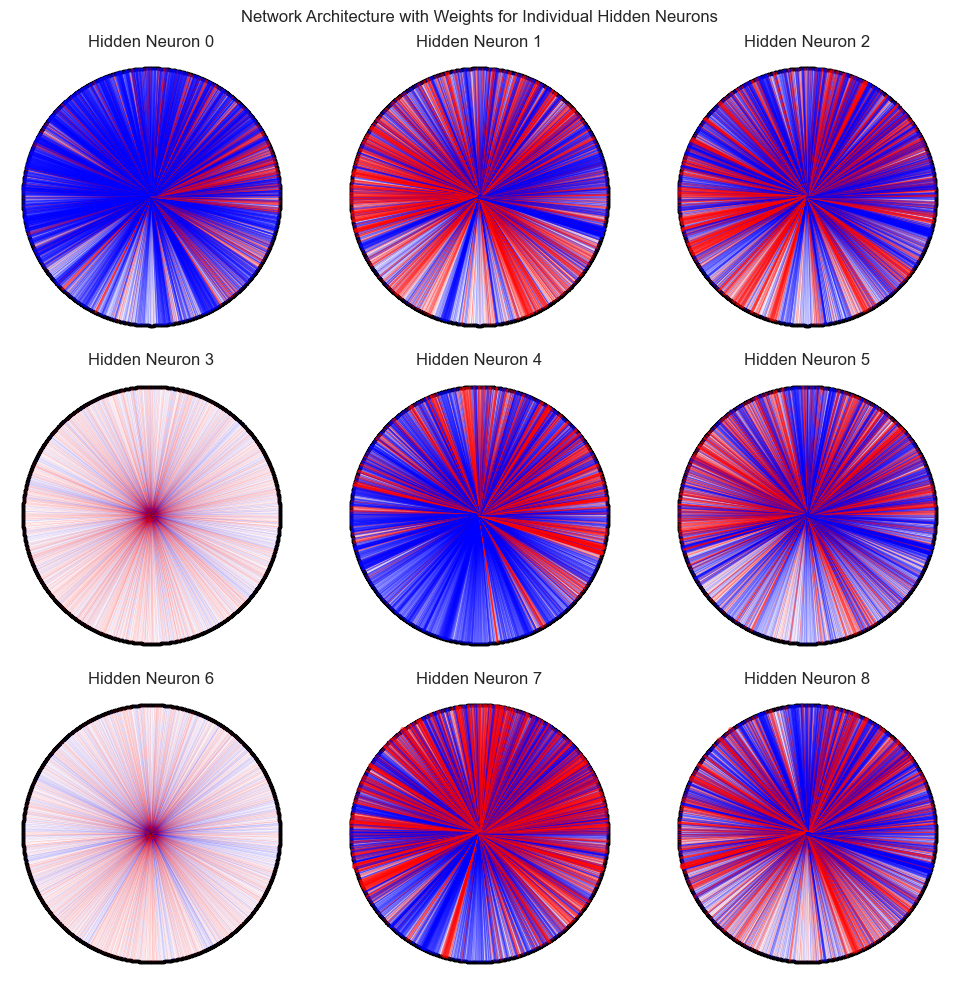

In [157]:
import matplotlib.pyplot as plt
import numpy as np

hidden1_weights = model.hidden_layer_1[0].weight.data.cpu().numpy()
weights_data = hidden1_weights

# Initialize positions for input neurons
input_size = weights_data.shape[1]
angle_input = np.linspace(0, 2 * np.pi, input_size, endpoint=False)
input_x = 10 * np.cos(angle_input)
input_y = 10 * np.sin(angle_input)

# Create 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx, ax in enumerate(axes.flatten()):
    # For each subplot, use one hidden neuron's weights
    if idx < len(weights_data):
        # Hidden neuron position (centered)
        hidden_x = 0
        hidden_y = 0

        # Plot input layer
        ax.scatter(input_x, input_y, s=2, c='black', label='Input Layer')

        # Plot a single hidden neuron
        ax.scatter(hidden_x, hidden_y, s=20, c='black', label='Hidden Neuron')

        # Add connections (weights)
        for i in range(input_size):
            weight = weights_data[idx, i]
            line_width = np.abs(weight) * 5  # Scale the line thickness
            color = 'blue' if weight > 0 else 'red'  # Positive weights in blue, negative in red
            ax.plot([input_x[i], hidden_x], [input_y[i], hidden_y], c=color, linewidth=line_width, alpha=0.5)

        # Remove spines to eliminate the box around each subplot
        for spine in ['top', 'right', 'bottom', 'left']:
            ax.spines[spine].set_visible(False)

        # Omit x and y axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Add legends and labels
        ax.set_aspect('equal', 'box')
        ax.set_title(f'Hidden Neuron {idx}')

plt.suptitle('Network Architecture with Weights for Individual Hidden Neurons')
plt.tight_layout()
plt.show()


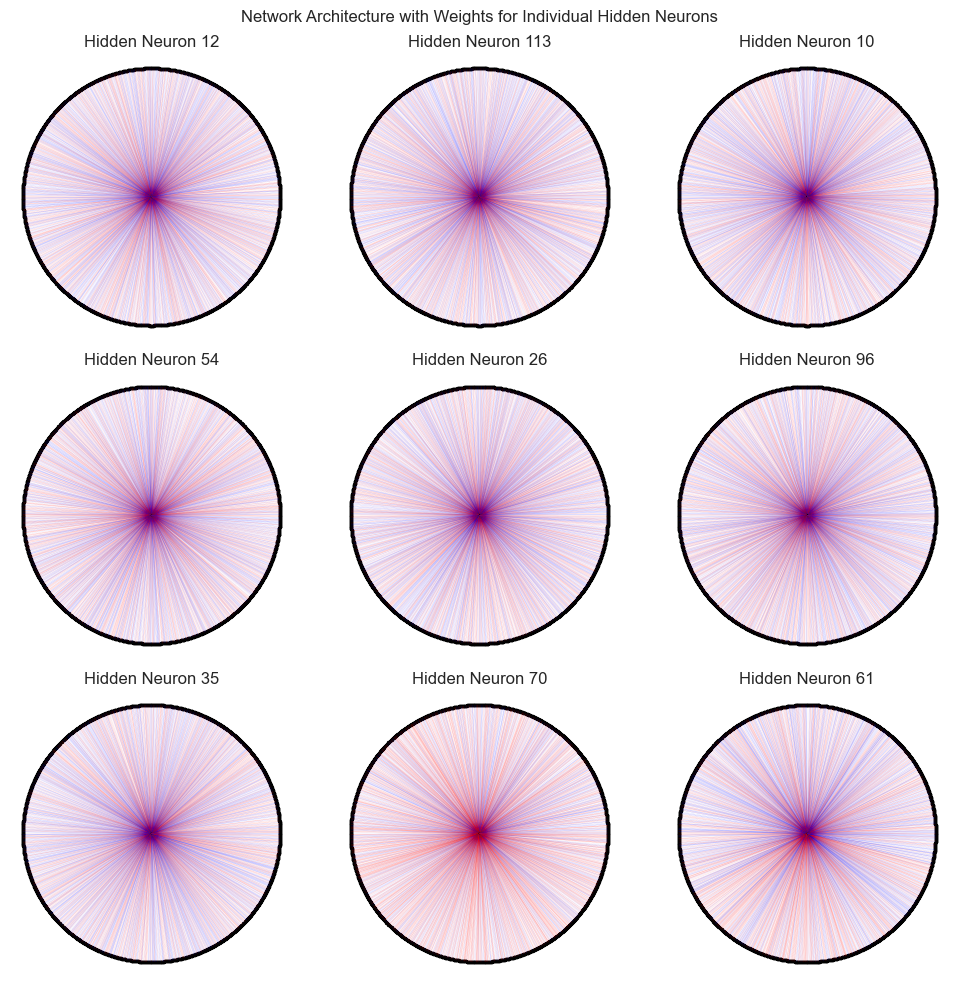

In [159]:
## REORDERED CIRCLE PLOT:

import matplotlib.pyplot as plt
import numpy as np

# Convert weights_data to a numpy array if they are in another format

hidden1_weights = model.hidden_layer_1[0].weight.data.cpu().numpy()
sum_abs_weights = np.sum(np.abs(hidden1_weights), axis=1)

# Get the indices that would sort the sum of absolute weights in descending order
sorted_indices = np.argsort(sum_abs_weights)#[::-1]

# Reorder the weights based on the sorted indices
hidden1_weights = hidden1_weights[sorted_indices]
weights_data = hidden1_weights
# Initialize positions for input neurons
input_size = weights_data.shape[1]
angle_input = np.linspace(0, 2 * np.pi, input_size, endpoint=False)
input_x = 10 * np.cos(angle_input)
input_y = 10 * np.sin(angle_input)

# Create 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx, ax in enumerate(axes.flatten()):
    # For each subplot, use one hidden neuron's weights
    if idx < len(weights_data):
        # Hidden neuron position (centered)
        hidden_x = 0
        hidden_y = 0

        # Plot input layer
        ax.scatter(input_x, input_y, s=2, c='black', label='Input Layer')

        # Plot a single hidden neuron
        ax.scatter(hidden_x, hidden_y, s=20, c='black', label='Hidden Neuron')

        # Add connections (weights)
        for i in range(input_size):
            weight = weights_data[idx, i]
            line_width = np.abs(weight) * 5  # Scale the line thickness
            color = 'blue' if weight > 0 else 'red'  # Positive weights in blue, negative in red
            ax.plot([input_x[i], hidden_x], [input_y[i], hidden_y], c=color, linewidth=line_width, alpha=0.5)

        # Remove spines to eliminate the box around each subplot
        for spine in ['top', 'right', 'bottom', 'left']:
            ax.spines[spine].set_visible(False)

        # Omit x and y axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Add legends and labels
        ax.set_aspect('equal', 'box')
        ax.set_title(f'Hidden Neuron {sorted_indices[idx]}')

plt.suptitle('Network Architecture with Weights for Individual Hidden Neurons')
plt.tight_layout()
plt.show()


# Network architectural plots (with mnean spectrum and colored)

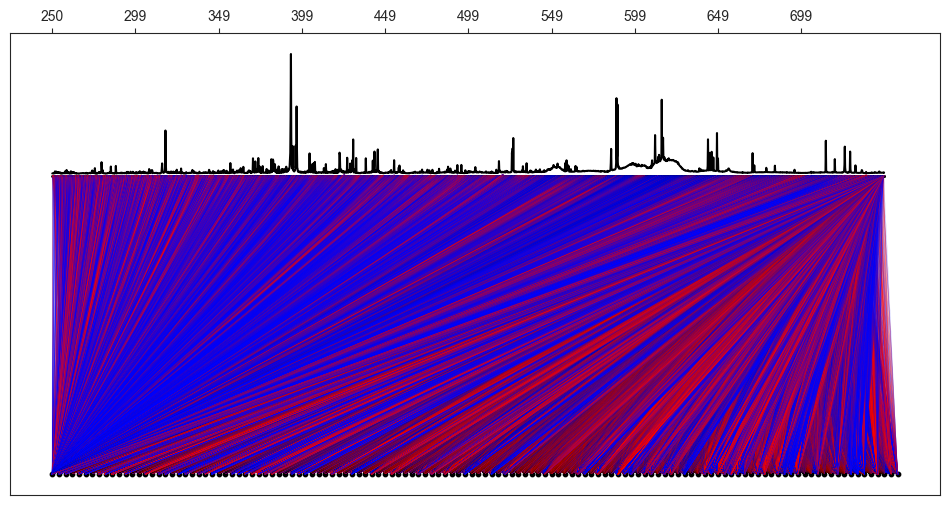

In [120]:


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Apply Seaborn style
sns.set_style("white")


weights_data = hidden1_weights.cpu().numpy()

# Initialize positions for input and hidden layer neurons
input_size = weights_data.shape[1]
hidden_size = weights_data.shape[0]
input_x = np.linspace(0, input_size - 1, input_size)
input_y = np.zeros(input_size)

# Stretch factor for hidden layer
scale_factor = 20

hidden_x = np.linspace(0, (hidden_size - 1) * scale_factor, hidden_size)
hidden_y = np.ones(hidden_size) * -5

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the neural network
ax.plot(input_x, (mean_spectrum / mean_spectrum.max() + 0.02)*2, c='black')  # Spectrum in black
ax.scatter(input_x, input_y, s=1, c='black')  # Neurons in black
ax.scatter(hidden_x, hidden_y, s=10, c='black')  # Neurons in black
ax.xaxis.tick_top()

# Add connections (weights)
for i in range(input_size):
    for j in range(hidden_size):
        weight = weights_data[j, i]
        line_width = np.abs(weight) * 2  # Adjust line width according to the weight value
        color = 'blue' if weight > 0 else 'red'  # Positive weights in blue, negative in red
        ax.plot([input_x[i], hidden_x[j]], [input_y[i], hidden_y[j]], c=color, linewidth=line_width, alpha=0.5)



# Use every n-th value for the tick locations and labels
tick_indices = np.arange(0, len(new_wave), 250)

tick_labels = [str(int(new_wave[i])) for i in tick_indices]  # Convert the values to string for labeling

# Set the x-ticks to be at the positions defined above
ax.set_xticks(tick_indices)
# Set the x-tick labels
ax.set_xticklabels(tick_labels)
# Remove y-axis ticks
ax.yaxis.set_ticks([])


# plt.tight_layout()
plt.show()



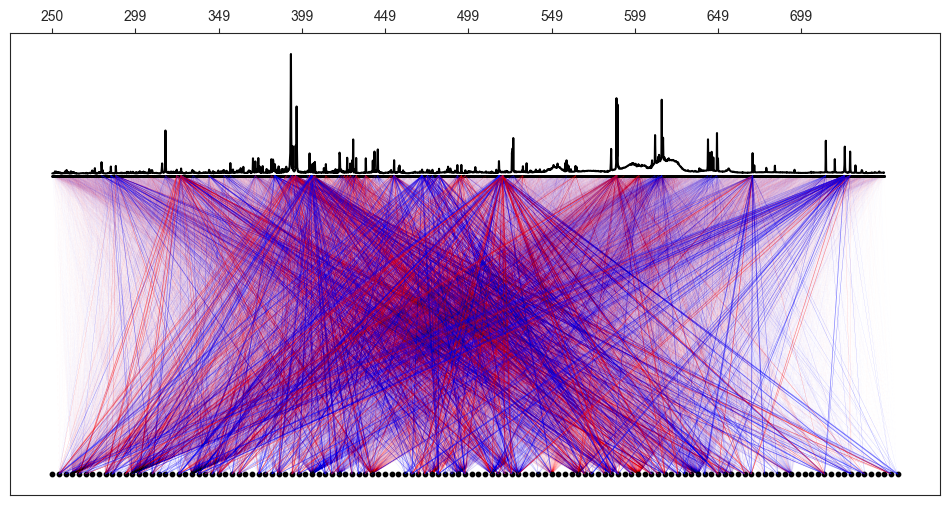

In [117]:


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Apply Seaborn style
sns.set_style("white")


weights_data = hidden1_weights.cpu().numpy()

# Initialize positions for input and hidden layer neurons
input_size = weights_data.shape[1]
hidden_size = weights_data.shape[0]
input_x = np.linspace(0, input_size - 1, input_size)
input_y = np.zeros(input_size)

# Stretch factor for hidden layer
scale_factor = 20

hidden_x = np.linspace(0, (hidden_size - 1) * scale_factor, hidden_size)
hidden_y = np.ones(hidden_size) * -5

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the neural network
ax.plot(input_x, (mean_spectrum / mean_spectrum.max() + 0.02)*2, c='black')  # Spectrum in black
ax.scatter(input_x, input_y, s=1, c='black')  # Neurons in black
ax.scatter(hidden_x, hidden_y, s=10, c='black')  # Neurons in black
ax.xaxis.tick_top()

# Add connections (weights)
for i in range(input_size):
    for j in range(hidden_size):
        weight = weights_data[j, i]
        line_width = np.abs(weight) * 2  # Adjust line width according to the weight value
        color = 'blue' if weight > 0 else 'red'  # Positive weights in blue, negative in red
        ax.plot([input_x[i], hidden_x[j]], [input_y[i], hidden_y[j]], c=color, linewidth=line_width, alpha=0.5)



# Use every n-th value for the tick locations and labels
tick_indices = np.arange(0, len(new_wave), 250)

tick_labels = [str(int(new_wave[i])) for i in tick_indices]  # Convert the values to string for labeling

# Set the x-ticks to be at the positions defined above
ax.set_xticks(tick_indices)
# Set the x-tick labels
ax.set_xticklabels(tick_labels)
# Remove y-axis ticks
ax.yaxis.set_ticks([])


# plt.tight_layout()
plt.show()



In [70]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_object = torch.rand(512, 2048)
tensor_object.to(device)

total_sum = 0.0  # variable to store the total sum
W_out = torch.zeros(tensor_object[0,:].size(0), tensor_object[0,:].size(0))
# Loop over the rows of the tensor_object
for i in range(tensor_object.size(0)):
    W = tensor_object[i, :]

    # Compute the outer product
    torch.outer(W, W, out=W_out)

    # Zero out the elements above the diagonal and far from the diagonal
    W_out.tril_(-1)
    W_out.triu_(-4)
    # print(torch.sum(W_out))
    # Sum the values and add to total_sum
    total_sum += torch.sum(W_out)

print("Total sum:", total_sum)


Total sum: tensor(1047492.8750)


In [ ]:
import torch

def sparseloc(weight_tensor):
    total_sum = 0.0  # variable to store the total sum

    # Loop over the rows of the weight_tensor
    for i in range(weight_tensor.size(0)):
        W = weight_tensor[i, :]

        # Compute the outer product directly to make it differentiable
        W_out = torch.outer(W, W)

        # Zero out the elements above the diagonal and far from the diagonal
        lower_triangle = torch.tril(W_out, -1)
        band_matrix = torch.triu(lower_triangle, -3)

        # Sum the absolute values and add to total_sum
        total_sum += torch.sum(torch.abs(band_matrix))

    return total_sum


In [71]:
%%writefile src/loss_penalization.py
"""
Contains functions for computing a custom term to regularize the loss function. 
"""
import torch

# def sparseloc(weight_tensor):
#     total_sum = 0.0  # variable to store the total sum

#     # Initialize W_out to zeros to save memory
#     W_out = torch.zeros(weight_tensor[0,:].size(0), weight_tensor[0,:].size(0))

#     # Loop over the rows of the weight_tensor
#     for i in range(weight_tensor.size(0)):
#         W = weight_tensor[i, :]

#         # Compute the outer product directly to make it differentiable
#         W_out = torch.outer(W, W)

#         # Zero out the elements above the diagonal and far from the diagonal
#         W_out.tril_(-1)
#         W_out.triu_(-4)

#         # Sum the absolute values and add to total_sum
#         total_sum += torch.sum(torch.abs(W_out))

#     return total_sum

import torch

def sparseloc(weight_tensor):
    total_sum = 0.0  # variable to store the total sum

    # Loop over the rows of the weight_tensor
    for i in range(weight_tensor.size(0)):
        W = weight_tensor[i, :]

        # Compute the outer product directly to make it differentiable
        W_out = torch.outer(W, W)

        # Zero out the elements above the diagonal and far from the diagonal
        lower_triangle = torch.tril(W_out, -1)
        band_matrix = torch.triu(lower_triangle, -3)

        # Sum the absolute values and add to total_sum
        total_sum += torch.sum(torch.abs(band_matrix))

    return total_sum


Overwriting src/loss_penalization.py


In [72]:
%%writefile src/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)




def resample_spectra_df(df, original_wavelengths, new_wavelengths):
    """
    Resample the spectra in dataset X (as a DataFrame) to new wavelengths using linear interpolation.

    Parameters:
    - df: DataFrame, where each row is a spectrum.
    - original_wavelengths: 1D array of original wavelengths.
    - new_wavelengths: 1D array of new wavelengths.

    Returns:
    - df_resampled: DataFrame of resampled spectra.
    """

    # Convert DataFrame to NumPy array
    X = df.values

    num_spectra = X.shape[0]
    X_resampled = np.zeros((num_spectra, len(new_wavelengths)))

    for i in range(num_spectra):
        f = interp1d(original_wavelengths, X[i, :], kind='linear', fill_value='extrapolate')
        X_resampled[i, :] = f(new_wavelengths)

    # Convert back to DataFrame
    df_resampled = pd.DataFrame(X_resampled, columns=new_wavelengths)

    return df_resampled

Overwriting src/utils.py


In [11]:
%%writefile src/train.py
"""
Trains a PyTorch model using device-agnostic code.
"""

import os
import torch
import data_setup, engine, model_builder, utils
import win32com.client
# Add this at the top of your script
import argparse

# Argument parser setup
parser = argparse.ArgumentParser(description='Training script for PyTorch model.')
parser.add_argument('--epochs', type=int, default=300, help='Number of epochs to run')
parser.add_argument('--reg_type', type=str, default='vanilla', choices=['vanilla', 'L1', 'sparseloc'], help='Type of regularization to apply')
parser.add_argument('--reg_lambda', type=float, default=0.1, help='Regularization strength')

args = parser.parse_args()

# Then use args to set your hyperparameters
NUM_EPOCHS = args.epochs
regularization_type = args.reg_type
reg_lambda = args.reg_lambda



# Setup hyperparameters
# NUM_EPOCHS = 300
# regularization_type = "L1" # "vanilla" "sparseloc"
# reg_lambda = 0.1
BATCH_SIZE = 128
INPUT_SHAPE = 7000  # Modify this based on your actual input vector length
OUTPUT_SHAPE = 12
HIDDEN_UNITS1 = 256  # Number of neurons in the first hidden layer
HIDDEN_UNITS2 = 128  # Number of neurons in the second hidden layer
LEARNING_RATE = 0.001


# Setup directories for data - modify these paths as needed
shell = win32com.client.Dispatch("WScript.Shell")
shortcut = shell.CreateShortCut('data/contest_TRAIN.h5.lnk')
train_dir = shortcut.Targetpath

# train_dir = "data/train"
# test_dir = "data/test"   # this should be val, and also used only if there is a specific dataset for valiadation data. 

# Setup target device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, classes = data_setup.create_dataloaders(
    train_dir=train_dir,
    batch_size=BATCH_SIZE,
    device = device,
    num_classes = OUTPUT_SHAPE
)

# Create model with help from model_builder.py
model = model_builder.SimpleMLP(
    input_shape=INPUT_SHAPE,
    hidden_units1=HIDDEN_UNITS1,
    hidden_units2=HIDDEN_UNITS2,
    output_shape=OUTPUT_SHAPE
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device,
             regularization_type = regularization_type,
             reg_lambda = reg_lambda)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="simple_mlp_model.pth")


Overwriting src/train.py


In [7]:
import gc  # Python's garbage collection module

# Explicitly delete variables
# del X_train
gc.collect()  # Call the garbage collector

# Clear GPU cache
torch.cuda.empty_cache()


In [ ]:
# %%writefile src/test_data.py
# """
# Contains functionality for creating PyTorch DataLoaders for 
# LIBS benchmark classification dataset.
# """

# import os
# import torch
# from torch.utils.data import DataLoader
# from load_libs_data import load_contest_train_dataset
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Normalizer, MinMaxScaler
# from siamese_net import prepare_triplets
# import numpy as np


# NUM_WORKERS = os.cpu_count()

# def create_dataloaders(
#     train_dir: str, 
#     #test_dir: str, 
#     batch_size: int, 
#     device: torch.device,
#     num_workers: int=NUM_WORKERS, 
#     split_rate: float=0.6,
#     random_st: int=102,
#     spectra_count: int=100
#     ):
#     """Creates training and validation DataLoaders.

#     Takes in a training directory directory path and split the data
#     to train/validation. After, it turns them into PyTorch Datasets and 
#     then into PyTorch DataLoaders.

#     Args:
#     train_dir: Path to training directory.
#     batch_size: Number of samples per batch in each of the DataLoaders.
#     num_workers: An integer for number of workers per DataLoader.

#     Returns:
#     A tuple of (train_dataloader, test_dataloader, class_labels).
#     Example usage:
#         train_dataloader, test_dataloader, class_labels, wavelengths = \
#         = create_dataloaders(train_dir=path/to/train_dir,
#                                 test_dir=path/to/test_dir,
#                                 transform=some_transform,
#                                 batch_size=32,
#                                 num_workers=4)
#     """



#     X, y, samples = load_contest_train_dataset(train_dir, spectra_count)
#     wavelengths = X.columns

#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_rate, random_state=random_st, stratify=samples, shuffle = True)
#     del X, y, samples

#     if True:
#       scaler =  Normalizer(norm = 'max')
#       X_train = scaler.fit_transform(X_train)
#       X_val = scaler.fit_transform(X_val)

#     # Convert data to torch tensors
#     X_train = torch.from_numpy(X_train).unsqueeze(1).float() # Add extra dimension for channels
#     X_val = torch.from_numpy(X_val).unsqueeze(1).float() # Add extra dimension for channels
#     y_train = torch.from_numpy(np.array(y_train)).long()
#     y_val = torch.from_numpy(np.array(y_val)).long()

#     #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     # If available, move data to the GPU
#     X_train.to(device)
#     X_val.to(device) 
#     y_train.to(device)
#     y_val.to(device)

#     # Prepare triplets for the training, validation
#     train_triplets = prepare_triplets(X_train, y_train)
#     val_triplets = prepare_triplets(X_val, y_val)


#     # Create PyTorch DataLoader objects for the training and validation sets
#     train_dataloader = DataLoader(train_triplets, batch_size=batch_size, shuffle=True)
#     val_dataloader = DataLoader(val_triplets, batch_size=batch_size, shuffle=True)


#     return train_dataloader, val_dataloader, y_train


In [86]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# import funcs
# import importlib
# importlib.reload(funcs)
# from funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
%%writefile src/prediction_engine.py
"""
Contains functionality for creating PyTorch DataLoaders for 
LIBS benchmark classification dataset.
"""

import os
import torch
from torch.utils.data import DataLoader
from load_libs_data import load_contest_test_dataset, load_contest_train_dataset
from sklearn.preprocessing import Normalizer, MinMaxScaler
import numpy as np


def create_dataloaders(
    test_dir: str, 
    test_labels_dir: str, 
    batch_size: int, 
    device: torch.device,
    pred_test: bool,
    ):
    """Creates training and validation DataLoaders.

    Takes in a training directory directory path and split the data
    to train/validation. After, it turns them into PyTorch Datasets and 
    then into PyTorch DataLoaders.

    Args:
    train_dir: Path to training directory.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

    Returns:
    A tuple of (train_dataloader, test_dataloader, class_labels).
    Example usage:
        train_dataloader, test_dataloader, class_labels, wavelengths = \
        = create_dataloaders(train_dir=path/to/train_dir,
                                test_dir=path/to/test_dir,
                                transform=some_transform,
                                batch_size=32,
                                num_workers=4)
    """

    if pred_test:
        X_test = load_contest_test_dataset(test_dir)
        y_test = np.loadtxt(test_labels_dir, delimiter = ',')
    else: # use with caution, only for predicting training embeddings
        X_test, y_test, _ = load_contest_train_dataset(test_dir)

    if True:
      scaler =  Normalizer(norm = 'max')
      X_test = scaler.fit_transform(X_test)

    # Convert data to torch tensors
    X_test = torch.from_numpy(X_test).unsqueeze(1).float() # Add extra dimension for channels
    y_test = torch.from_numpy(np.array(y_test)).long()


    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # If available, move data to the GPU
    X_test.to(device)
    y_test.to(device)



    # Create PyTorch DataLoader objects for the training and validation sets
    pred_test_loader = DataLoader(X_test, batch_size=batch_size)


    return pred_test_loader, y_test

def predict_test(
                model: torch.nn.Module, 
                dataloader: torch.utils.data.DataLoader,
                device: torch.device,
                test_dir: str, 
                test_labels_dir: str,
                batch_size: int,
                y_test
                ):
    X_test_pred=[]
    with torch.no_grad():
        for data in dataloader:
            input = data.to(device)
            output = (model.forward_once(input)).cpu()
            output = np.array(output)
            X_test_pred.append(output)
    X_test_pred = np.concatenate(X_test_pred, axis = 0)
    return X_test_pred






Overwriting src/prediction_engine.py


In [63]:
%%writefile src/prediction.py

import torch
import prediction_engine
import siamese_net
import numpy as np

NUM_EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.0001
INPUT_SIZE = 2500
OUTPUT_SIZE = 12
CHANNELS=50
KERNEL_SIZES=[50, 10]
STRIDES=[2, 2]
PADDINGS=[1, 1]
HIDDEN_SIZES=[256]

# Setup directories
#test_dir = "datasets/contest_TEST.h5"
test_labels_dir = "datasets/test_labels.csv"
model_dir = 'models/final_model2_dashing_dream_256b_50ep.pth'
test_dir = "datasets/contest_TRAIN.h5"


# Setup target device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create DataLoaders with help from data_setup.py
test_dataloader, y_test = prediction_engine.create_dataloaders(
    test_dir=test_dir,
    test_labels_dir=test_labels_dir,
    batch_size=BATCH_SIZE,
    device = device,
    pred_test = False # USE WITH CAUTION, turn to 'False' if you want to get embeddings of the training data
)


saved_state_dict = torch.load(model_dir, map_location=torch.device('cpu'))

# Create a new instance of your model
model = siamese_net.SiameseNetwork(
    input_size=INPUT_SIZE, 
    output_size=OUTPUT_SIZE, 
    channels=CHANNELS, 
    kernel_sizes=KERNEL_SIZES, 
    strides=STRIDES, 
    paddings=PADDINGS, 
    hidden_sizes=HIDDEN_SIZES
).to(device)
# Load the saved state into the new model instance
model.load_state_dict(saved_state_dict)

#todo save this to a file
prediction_X_test = prediction_engine.predict_test(
                    model=model, 
                    dataloader=test_dataloader,
                    device=device,
                    test_dir=test_dir, 
                    test_labels_dir=test_labels_dir,
                    batch_size=BATCH_SIZE,
                    y_test=y_test
                    )


np.save('datasets/prediction_X_train_dashing_dream.npy', prediction_X_test)        
np.save('datasets/y_train.npy', y_test)          

#https://colab.research.google.com/drive/15D5vAYkhbAs5-txhYTCb_Fp2jiCnHXVN#scrollTo=82F_qINOBbkL

Overwriting src/prediction.py


In [17]:
import numpy as np
test = np.load('datasets/prediction_X_test.npy')
test.shape

(20000, 12)